<a href="https://colab.research.google.com/github/chanarat989/word_segmentation_model/blob/main/Named_Entity_Recognition_POS_CH_11Sep2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Home work #4  pos tags โดย นายชนะรัฐ ภาระอังกูร นักศีกษาหลักสูตร Certificate 

# Pip everything

# Mount Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [14]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [28]:
!ls LST20Corpus

ls: cannot access 'LST20Corpus': No such file or directory


In [29]:
from datasets import load_dataset

#lst_dataset = load_dataset('lst20', data_dir='LST20Corpus/', cache_dir='huggingface_cache')
lst_dataset = load_dataset('lst20', data_dir='LST20_Corpus', cache_dir='huggingface_cache')

Using custom data configuration default-data_dir=LST20_Corpus
Reusing dataset lst20 (huggingface_cache/lst20/default-data_dir=LST20_Corpus/0.0.0/e1b2a921fb011578ab43ddbbf789f3c500d62cb2df8ae4ed4b60bae8e4c0d3ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
lst_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 63310
    })
    validation: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5620
    })
    test: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5250
    })
})

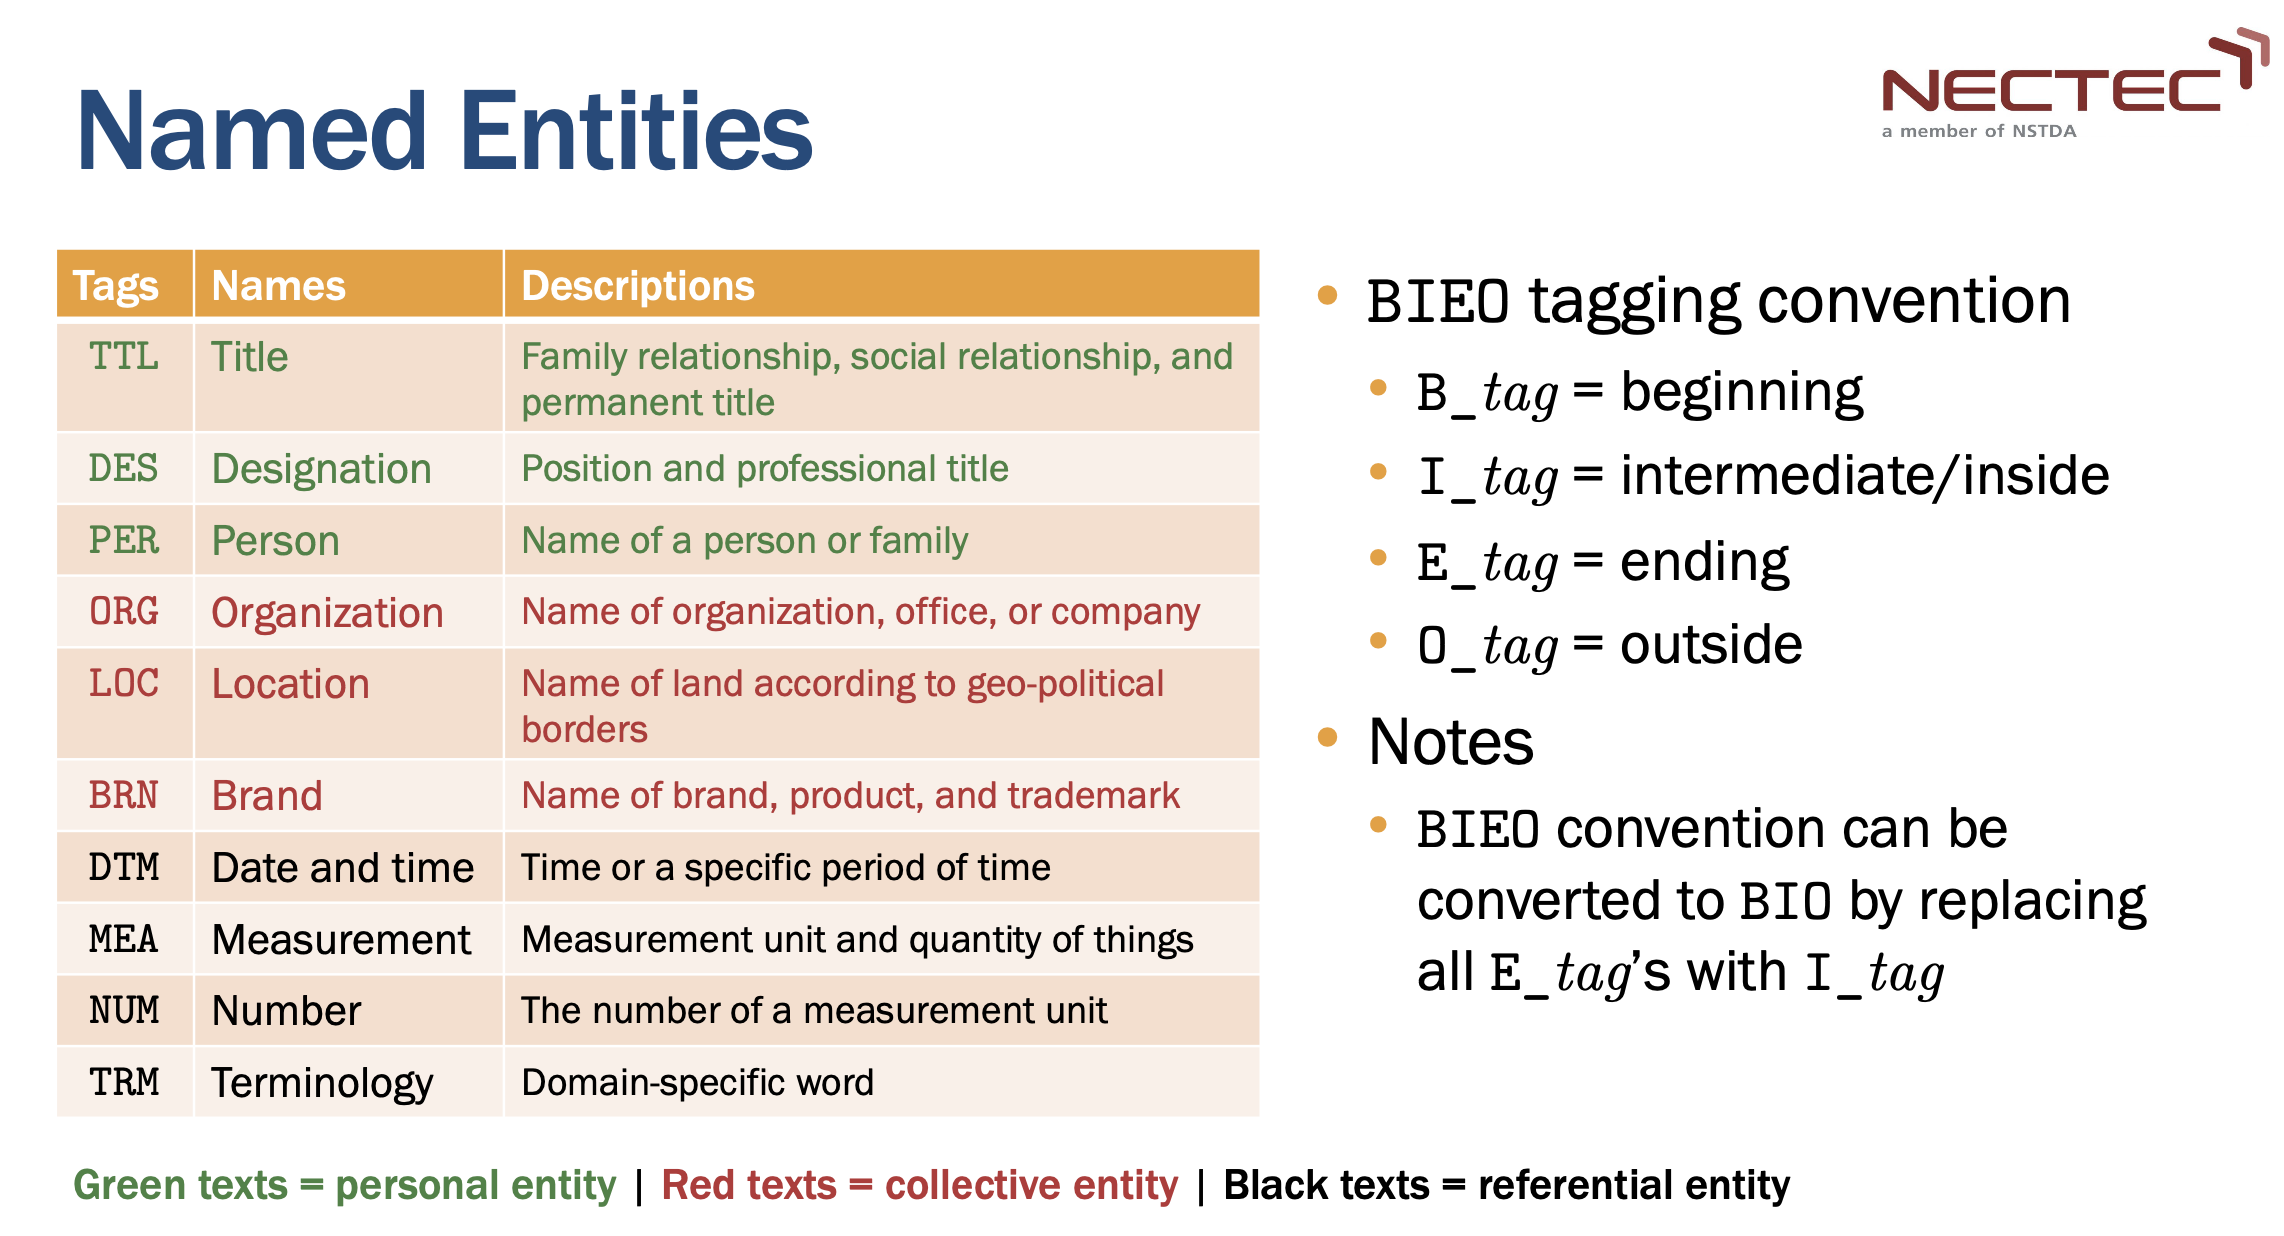

# NER tags

Huggineface tags | LST20 tags | Huggineface tags | LST20 tags
-----------------|------------|------------------|-----------
1  | B_BRN | 6  | B_NUM
11 | I_BRN | 16 | I_NUM
21 | E_BRN | 26 | E_NUM
-
2  | B_DES | 7  | B_ORG
12 | I_DES | 17 | I_ORG
22 | e_DES | 27 | E_ORG
-
3  | B_DTM | 8  | B_PER
13 | I_DTM | 18 | I_PER
23 | E_DTM | 28 | E_PER
-
4  | B_LOC | 9  | B_TRM
14 | I_LOC | 19 | I_TRM
24 | E_LOC | 29 | E_TRM
-
5  | B_MEA | 10 | B_TTL
15 | I_MEA | 20 | I_TTL
25 | E_MEA | 30 | E_TTL



In [31]:
labels = {
    '0': 'O',
    '1':'B_BRN',
    '11':'I_BRN',
    '21':'E_BRN',
    '2':'B_DES',
    '12':'I_DES',
    '22':'e_DES',
    '3':'B_DTM',
    '13':'I_DTM',
    '23':'E_DTM',
    '4':'B_LOC',
    '14':'I_LOC',
    '24':'E_LOC',
    '5':'B_MEA',
    '15':'I_MEA',
    '25':'E_MEA',
    '6':'B_NUM',
    '16':'I_NUM',
    '26':'E_NUM',
    '7':'B_ORG',
    '17':'I_ORG',
    '27':'E_ORG',
    '8':'B_PER',
    '18':'I_PER',
    '28':'E_PER',
    '9':'B_TRM',
    '19':'I_TRM',
    '29':'E_TRM',
    '10':'B_TTL',
    '20':'I_TTL',
    '30':'E_TTL'
}

In [33]:
lst_dataset['train'][1]['tokens']

['1', '_', 'กันยายน', '_', '2550', '_', '12:21', '_', 'น.']

In [34]:
lst_dataset['train'][0]['pos_tags']

[0, 1, 1, 1, 2, 0, 2, 4, 0, 12, 1, 0]

B_ may not followed by I or E

# Classic approach: CRF
- Use __sklearn_crfsuite__
- Extract __features__ from each word in form of __dict__ 

In [35]:
lst_dataset['train']

Dataset({
    features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
    num_rows: 63310
})

In [36]:
import pythainlp

In [37]:
import numpy as np
np.sum([1 for i in '1233' if i in '0123456789' ])

4

In [38]:
def is_thai_word(word):
  n = pythainlp.util.countthai(word, ignore_chars="")
  return (len(word)>0) and (n > 0.9*len(word))

def is_number(word):
  n = np.sum([1 for i in word if i in '0123456789' ])
  return (len(word)>0) and (n > len(word)-3)

def word2features(lst_sentence, i):

  word = lst_sentence['tokens'][i]
  prev_word = lst_sentence['tokens'][i-1] if i>0 else ''
  prev2_word = lst_sentence['tokens'][i-2] if i-2>0 else ''

  features = {
    'word'           : word,
    'is_thai'        : is_thai_word(word),
    'is_number'      : is_number(word),
    'prev_word'      : prev_word,
    'prev_is_thai'   : is_thai_word(prev_word),
    'prev_is_number' : is_number(prev_word),
    'prev2_word'      : prev2_word,
    'prev2_is_thai'   : is_thai_word(prev2_word),
    'prev2_is_number' : is_number(prev2_word),
  }

  return features

def sent2features(lst_sentence):
  return [word2features(lst_sentence, i) for i in range(len(lst_sentence['tokens']))]

def sent2labels(lst_sentence):
  return [str(lst_sentence['pos_tags'][i]) for i in range(len(lst_sentence['tokens']))] #use pos tags as label

# Sklearn-crfsuite requires input = seq of features, output = seq of string

In [39]:
import numpy as np

sent2features(lst_dataset['train'][0])

[{'is_number': False,
  'is_thai': True,
  'prev2_is_number': False,
  'prev2_is_thai': False,
  'prev2_word': '',
  'prev_is_number': False,
  'prev_is_thai': False,
  'prev_word': '',
  'word': 'สุรยุทธ์'},
 {'is_number': False,
  'is_thai': True,
  'prev2_is_number': False,
  'prev2_is_thai': False,
  'prev2_word': '',
  'prev_is_number': False,
  'prev_is_thai': True,
  'prev_word': 'สุรยุทธ์',
  'word': 'ยัน'},
 {'is_number': False,
  'is_thai': True,
  'prev2_is_number': False,
  'prev2_is_thai': False,
  'prev2_word': '',
  'prev_is_number': False,
  'prev_is_thai': True,
  'prev_word': 'ยัน',
  'word': 'ปฏิเสธ'},
 {'is_number': False,
  'is_thai': True,
  'prev2_is_number': False,
  'prev2_is_thai': True,
  'prev2_word': 'ยัน',
  'prev_is_number': False,
  'prev_is_thai': True,
  'prev_word': 'ปฏิเสธ',
  'word': 'ลงนาม'},
 {'is_number': True,
  'is_thai': False,
  'prev2_is_number': False,
  'prev2_is_thai': True,
  'prev2_word': 'ปฏิเสธ',
  'prev_is_number': False,
  'prev_is_

In [40]:
len(lst_dataset['train'])

63310

In [41]:
#แต่ละคำ แต่ละประโยค ดึง feature ออกมา
X = [sent2features(s) for s in lst_dataset['train']] 
y = [sent2labels(s) for s in lst_dataset['train']] 

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [43]:
len(X_train), len(X_test)

(56979, 6331)

In [44]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [45]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=50
)
crf.fit(X_train, y_train)

CPU times: user 4min 16s, sys: 1.18 s, total: 4min 17s
Wall time: 4min 16s


In [46]:
y_pred = crf.predict(X_test)

In [47]:
e=metrics.flat_f1_score(y_test, y_pred, average='weighted') #f1 score accuracy

print(e)

0.9567302183480814


In [48]:
lbl = [ labels[i] for i in crf.classes_ ]
yy_test = [ [labels[i] for i in y] for y in y_test  ]
yy_pred = [ [labels[i] for i in y] for y in y_pred  ]

print(metrics.flat_classification_report(
    yy_test, yy_pred, labels=lbl, digits=3
))

              precision    recall  f1-score   support

       B_DTM      0.934     0.944     0.939     24383
           O      0.970     0.976     0.973     74998
       B_BRN      0.961     0.959     0.960     57536
       B_ORG      0.993     0.988     0.991      8762
       B_LOC      0.908     0.914     0.911     14091
       B_DES      1.000     1.000     1.000     45253
       B_MEA      0.936     0.930     0.933     10796
       B_PER      0.965     0.947     0.956      7847
       B_TTL      0.893     0.834     0.862      4891
       B_TRM      0.859     0.853     0.856      5736
       B_NUM      0.837     0.856     0.846      9044
       I_BRN      0.879     0.831     0.854      3158
       I_DES      1.000     0.999     1.000      2696
       I_DTM      0.935     0.876     0.904       571
       I_LOC      0.667     0.083     0.148        24
       I_MEA      0.778     0.389     0.519        18

    accuracy                          0.957    269804
   macro avg      0.907   

***
# Deep learning approach

## Create vocab first

In [49]:
train_text  = []
for i in range(len(lst_dataset['train'])):
  s = ' '.join(lst_dataset['train'][i]['tokens'])
  train_text.append(normalize(s.replace('_', '')))

In [50]:
from sklearn.feature_extraction.text import CountVectorizer #นับคำศัพท์

vectorizer = CountVectorizer(token_pattern=r"[^\s]*", 
                             max_df=0.8, min_df=10)
vectorizer.fit(train_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.8, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='[^\\s]*', tokenizer=None,
                vocabulary=None)

In [51]:
# we will use 0 to pad sequence ..พวก neural input fix so if input less than the fix length need to pad .. now use 0 for padding 
# 1 for unknown+
#first index padding 
#second index is unknow 
#BPEM use pad -1
unk = 1

# then we start vocab from 2
vocab = {}
for i,v in enumerate(vectorizer.vocabulary_):
  vocab[v] = 2 + i

num_vocab = len(vectorizer.vocabulary_) + 2
print(num_vocab)

7471


In [52]:
def encode(sent, vocab):
  return [vocab[s] if s in vocab else 1 for s in sent] 

In [53]:
encode(lst_dataset['train'][0]['tokens'], vocab) #use this index ..(encoe) feed to neural network

[2, 3, 4, 1, 1, 1, 1, 5, 6, 7, 8, 9]

In [54]:
' '.join(lst_dataset['train'][0]['tokens'])

'สุรยุทธ์ ยัน ปฏิเสธ ลงนาม _ MOU _ กับ อียู ไม่ กระทบ สัมพันธ์'

In [55]:
lst_dataset['train'][10]['pos_tags']

[0,
 0,
 1,
 3,
 3,
 0,
 0,
 1,
 4,
 0,
 7,
 1,
 2,
 0,
 2,
 5,
 12,
 1,
 4,
 7,
 1,
 4,
 0,
 4,
 0,
 3,
 1,
 0,
 4,
 11,
 3,
 5,
 1,
 3,
 11,
 6,
 6,
 1,
 11,
 6,
 6,
 3,
 0,
 3,
 0,
 1,
 1,
 1,
 1,
 5,
 1,
 0,
 0,
 7,
 1,
 3,
 1,
 7,
 1,
 3,
 1,
 7,
 1,
 1,
 3,
 0,
 9,
 1,
 1,
 0,
 1,
 3,
 0,
 0,
 0,
 3,
 5,
 5,
 1,
 0,
 1,
 6]

In [56]:
#use data generator to train model 
#ตัดความยาวของ index encode ที่วิ่งเข้ามา  ตัดตามความยาว tokem 
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, 
                 lst_data, 
                 vocab, num_tags,
                 batch_size, max_length, 
                 shuffle=True):
            
        self.vocab = vocab
        self.num_tags = num_tags
        self.X     = []
        self.Y     = []
        z = []
        for i in range(10000): # len(lst_data)): 
          c = encode(lst_data[i]['tokens'], vocab)
          for j in range(0, len(c), max_length):
            x = c[j:j+max_length]  # x is index คำ
            y = lst_data[i]['pos_tags'][j:j+max_length] #NER tag

            self.X.append(x)
            self.Y.append(y)
            z.append(np.sum(y))

        self.batch_size = batch_size
        self.max_length = max_length
        self.shuffle    = shuffle
        self.indices    = np.arange(len(self.X))
        if self.shuffle:
          np.random.shuffle(self.indices)

    def on_epoch_end(self):
        if self.shuffle:
          np.random.shuffle(self.indices)
    
    def __len__(self): # Return total number of batches
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index): #return input, index 
        offset    = index*self.batch_size
        batch_in  = np.zeros((self.batch_size, self.max_length)) # 0 = padding
        batch_out = np.zeros((self.batch_size, self.max_length))
        for i in range(self.batch_size):
            idx = int(self.indices[ offset + i ])
            l = len(self.X[idx])
            batch_in[i, :l]  = self.X[idx]

            for j in range(l):
              batch_out[i, j] = self.Y[idx][j] 

        return batch_in, batch_out


In [57]:
max_length = 64
emb_dim    = 128 #embeding layer ยาวเท่านี้ 
vocab_size = num_vocab
num_tags   = len(labels)
batch_size = 32

In [58]:
data = DataGenerator(lst_dataset['train'], vocab, num_tags, batch_size, max_length, shuffle=True)

## Model

In [59]:
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

Input max_length -> sequence ของ index คำศัพท์ ความยาว max_length คำ
สมมติว่า max_length=64 แปลว่า sequence นี้ยาว 64 คำ
แปลว่าเราก็ต้องทาย output 64 ตำแหน่ง
แต่ละตำแหน่งมีได้ num_tags=31 ค่า
output shape ของ network ต้องเป็น (64,31)

### Basic LSTM , Bidirection


In [60]:
#Basic LSTM 
# Input max length - > sequence ของ index คำศัพท์ ความยาว max length คำ 
#สมมติ max length=64 แปลว่าเราต้องการทาย output 64 ตำแหน่ง 
#แต่ละตำแหน่ง มี 31 tag 
input = Input(shape=(max_length))

x = Embedding(vocab_size, emb_dim)(input) #embeding layer .. convert คำ to one hot 

#x = LSTM(8, return_sequences=True)(x) #LSTM 8 unit
#x = LSTM(16, return_sequences=True)(x)
#x = LSTM(32, return_sequences=True)(x)

#x = LSTM(32, return_sequences=False)(x) #False merge value 
#x = Conv1D(32, kernel_size=3, padding='same')(x)
x = Bidirectional(LSTM(8, return_sequences=True),merge_mode='concat')(x)
x = Bidirectional(LSTM(16, return_sequences=True),merge_mode='concat')(x)
x = Bidirectional(LSTM(32, return_sequences=True),merge_mode='concat')(x)

x = Dense(num_tags, activation='softmax')(x) #Dence is 31 .. tag

model = Model(inputs=[input], outputs=[x])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 128)           956288    
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 16)            8768      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 64)            16640     
_________________________________________________________________
dense (Dense)                (None, 64, 31)            2015      
Total params: 987,935
Trainable params: 987,935
Non-trainable params: 0
_______________________________________________________

In [61]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam') #
#model.compile(loss='categorical_crossentropy', optimizer='adam') #need fix at 31


In [62]:
model.fit(data, epochs=5)

Epoch 1/5
410/410 [==============================] - 52s 93ms/step - loss: 1.1294
Epoch 2/5
410/410 [==============================] - 38s 93ms/step - loss: 0.3433
Epoch 3/5
410/410 [==============================] - 38s 93ms/step - loss: 0.1824
Epoch 4/5
410/410 [==============================] - 39s 94ms/step - loss: 0.1333
Epoch 5/5
410/410 [==============================] - 38s 93ms/step - loss: 0.1123


In [63]:
X,Y = data[10]
Z = model.predict(X)

for i in range(X.shape[0]):
  print(i)
  print(Y[i].astype(np.int))
  print(np.argmax(Z[i], axis=1)) #ใน 31 class .. tag .. ให้สรุป best predict result 

0
[ 3  0  0  1  5  1  0  0  9 10  4  0  3  1 11  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 3  0  0  1  5  1  0  0  9 10  4  0  3  1  6  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1
[ 3  1  7  1  4  9  0  1  6  4  0  3  7  3  5  6  1  0  0  0 10  4  2  8
  2  4  0  9  5  1  0  3  1  0  7  1  4  0  0  1  0  9  1  2  2  3  7  1
  1  0  9  1  7  1  1  1  0  0  1  0  0  0  0  0]
[3 1 7 1 4 9 0 1 6 4 0 4 7 3 5 6 1 0 0 0 0 4 2 8 2 4 0 9 5 1 0 3 1 0 7 1 4
 0 0 4 0 9 1 2 2 3 7 1 1 0 9 1 7 1 1 1 0 0 1 0 0 0 0 0]
2
[ 0  0  2  0  2  0  0  0  1  4  3  2  0  0  2  0  2  0  6  6  1  3  0  0
  1  5  1  7  1  0  4  2  0  5  2  3  1  5  3  7  1  7  1  6  0  3  2  0
  3  2 11 12  1  0  0  0 11  4  0  0  1  5  6  6]
[ 0  0  2  0  2  0  0  0  1  4  3  2  0  0  2  0  2  0  6  6  1  3  0  0
  1  5

In [64]:
np.argmax(Z[0], axis=1)

array([ 3,  0,  0,  1,  5,  1,  0,  0,  9, 10,  4,  0,  3,  1,  6,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

### LSTM+CRF (experimental)

In [65]:
input = Input(shape=(max_length))

x = Embedding(vocab_size, emb_dim)(input)

#Add some LSTM here!
x = Bidirectional(LSTM(8, return_sequences=True),merge_mode='concat')(x)
x = Bidirectional(LSTM(16, return_sequences=True),merge_mode='concat')(x)
x = Bidirectional(LSTM(32, return_sequences=True),merge_mode='concat')(x)

#Then go CRF 
x = tf_crf_layer.layer.CRF(num_tags)(x) #use num_tags .. use wrapper from git hub

model = Model(inputs=[input], outputs=[x])

model.summary()

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 128)           956288    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64, 16)            8768      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64, 64)            16640     
_________________________________________________________________
crf (CRF)                    (None, 64)                3038      
Total params: 988,958
Trainab

In [66]:
model.compile(loss=tf_crf_layer.loss.crf_loss, optimizer='adam') #use loss function in CRF 

In [70]:
model.fit(data, epochs=5) #chage to 5 epochs 

Epoch 1/5
410/410 [==============================] - 123s 300ms/step - loss: 7.4287
Epoch 2/5
410/410 [==============================] - 122s 298ms/step - loss: 6.3376
Epoch 3/5
410/410 [==============================] - 122s 297ms/step - loss: 5.6800
Epoch 4/5
410/410 [==============================] - 122s 297ms/step - loss: 5.1965
Epoch 5/5
410/410 [==============================] - 124s 302ms/step - loss: 4.8302


##เปรีบเทียบ Lost ที่ epochs 5 from deep learning LSTM + CRF จะสูงกว่า Basic LSTM แต่ไก้ผลดีกว่าใช้ CRF อย่างเดียว  

In [68]:
X,Y = data[10]
Z = model.predict(X)

for i in range(X.shape[0]):
  print(i)
  print(Y[i].astype(np.int))
  print(Z[i].astype(np.int))

0
[6 1 4 7 1 0 1 2 3 7 1 0 4 0 9 1 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[6 1 4 7 1 0 1 2 3 7 1 0 4 0 9 1 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1
[ 2  3  3  5  1  0  1  4  0  1  4  0  5  7  1  0  2  3  4  0  0  0  5  1
  0  1  1  2 12  1  0  1  2  3  1  1  9 10  3  1  6  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 2  3  3  5  1  0  1  4  0  1  4  0  5  7  1  0  2  3  1  0  0  0  5  1
  0  1  1  2 12  1  0  1  2  3  1  1  9 10  3  1  6  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
2
[ 0  0  1  0  1  3  0  0 10  9  1  6  4  0  2  8  2 10  2  0  2  8  2  0
  2  0  0  2  0  0  1  2  2  0  2  8  2  2  0  0  1  4  2  0  0  2  0  0
  0  0  1  0  0  1  0  5  1  1  4  4  0  0  2  8]
[ 0  0  1  0  1  3  0  0 10  9  1  6  4  0  2  8  2 10  2  0  2  8  2  0
  2  0  0  2  2  0  1  2  2  1  2  8  2  2  0  0  1  4  2  0  0  2  2  

In [69]:
Z[i]

array([ 0,  0,  4,  0,  0,  1, 10,  8,  2,  1,  3,  2,  1,  3,  0,  0,  2,
        1,  0,  1,  9,  2, 12,  5,  1,  7,  1,  6,  5,  2,  3,  0,  1,  0,
        2,  1,  0,  4,  0,  0,  2,  3,  1,  7,  1,  7,  7,  1,  4,  4,  0,
        0,  3,  1,  7,  1,  0,  4,  0,  0,  2,  4,  0,  0], dtype=int32)